In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics


from sklearn import preprocessing
from xgboost import XGBClassifier

# Other Libraries
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter 
rs = 42
def compute_metrics (y_te2,y_p,string):
    print('\n %s'%string)
    print('CONFUSION MATRIX')
    print(metrics.confusion_matrix(y_te2,y_p))
    print(classification_report(y_te2, y_p))
    print('\nROC CURVE: %2.2f'%roc_auc_score(y_te2,y_p))

def plotting_ROC_curve(X_te,y_te,model):
    plt.figure()
    metrics.plot_roc_curve(model,X_te,y_te)
    plt.plot([0,1],[0,1],label='baseline',c='red')
    plt.legend(loc='lower right')
    plt.show()
    
def Ratio10(y,string):
    suma = Counter(y)[0]+Counter(y)[1]
    print('\n'+string)  
    print(Counter(y))
    print('0: %3.2f%%\n1: %3.2f%%' % (100*Counter(y)[0]/suma,100*Counter(y)[1]/suma))

def histo(data,var):
    fig=plt.figure()
    colors = np.array(['#0101DF','#DF0101','#01DF01'])
    sns.countplot(var,data=data,palette=colors)
    plt.title('0/1 Distribution (0: No Stalling || 1: Stalling Event',fontsize=14)
    plt.show()
    
def featImp(model,features):
    print('Features: %s' %features)
    feat_imp = pd.Series(model.feature_importances_, features).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

Using TensorFlow backend.


Index(['No.', 'Time', '∆t', 'Protocol', 'pkt_len', 'ip_len', 'tcp_hea_len',
       'tcp_flag_ack', 'tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg',
       'tcp_flag_psh', 'tcp_flag_rst', 'tcp_flag_syn', 'tcp_flag_fin',
       'tcp_win_si2', 'delay', 'capture', 'prebuffering', 'stalling_event'],
      dtype='object')

dataset[stalling_event]
Counter({0: 1426743, 1: 113031})
0: 92.66%
1: 7.34%

y (SMOTE)
Counter({0: 1426743, 1: 1426743})
0: 50.00%
1: 50.00%


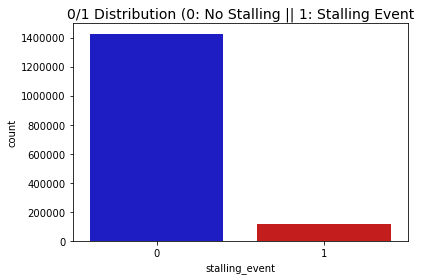

In [2]:
dataset = pd.read_csv('../../output/df_general.csv', sep=',')
dataset = dataset.dropna()

print(dataset.columns)
Ratio10(dataset['stalling_event'],'dataset[stalling_event]')
histo(dataset,'stalling_event')

y = dataset['stalling_event']
X = dataset.drop(['No.','Protocol','prebuffering','Time','delay','capture','stalling_event'],axis=1)

smote = SMOTE(sampling_strategy='minority',random_state=rs,n_jobs=-1)
X, y = smote.fit_sample(X.values, y.values)
Ratio10(y,'y (SMOTE)')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

norm = preprocessing.MinMaxScaler()
X = norm.fit_transform(X)

In [ ]:
'''model = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=5,
                       min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', 
                       nthread=4, scale_pos_weight=1, seed=rs)
model.fit(X_train,y_train)'''

In [ ]:
'''featImp(model,['∆t', 'pkt_len', 'ip_len', 'tcp_hea_len', 'tcp_flag_ack',
       'tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg', 'tcp_flag_psh',
       'tcp_flag_rst', 'tcp_flag_syn', 'tcp_flag_fin', 'tcp_win_si2'])'''


In [3]:
from sklearn.model_selection import GridSearchCV   #Perforing grid search
param_test1 = {
    'n_estimators':range(1000,5100,1000),
    'learning_rate':[0.001,0.01,0.1],
    'max_depth':range(5,10,1),
    'gamma':[0.01,0.1,0.2],
    'subsample':[0.6,0.7,0.8,0.9],
    'colsample_bytree':[0.6,0.7,0.8,0.9]
    
}
gsearch1 = GridSearchCV(estimator= XGBClassifier( max_features='sqrt',
                                                  min_child_weight=1,
                                                  objective= 'binary:logistic', 
                                                  seed=rs,
                                                  scale_pos_weight=1
                                                  ), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=3,verbose=1) #probar scoring 'roc_auc'
gsearch1.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 103.7min finished
c:\users\usuario\pycharmprojects\stallingevents\venv\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, max_features='sqrt',
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=4,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(100, 1700, 500)},
             pre_dispatch='2*n_jobs', refit=True, return_train_sc

In [ ]:
print(gsearch1.cv_results_)
print(gsearch1.best_params_)
print(gsearch1.best_score_)








[0.00838422 0.00362707 0.00420873 0.00317106 0.0100402  0.
 0.         0.         0.00742942 0.01928242 0.0075601  0.00237014
 0.93392664]

 XGBoost
CONFUSION MATRIX
[[209811  74927]
 [100472 185488]]
              precision    recall  f1-score   support

           0       0.68      0.74      0.71    284738
           1       0.71      0.65      0.68    285960

    accuracy                           0.69    570698
   macro avg       0.69      0.69      0.69    570698
weighted avg       0.69      0.69      0.69    570698


ROC CURVE: 0.69


<Figure size 432x288 with 0 Axes>

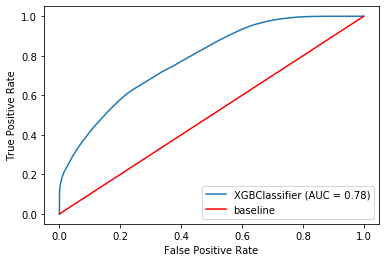

In [11]:
'''y_pred = model.predict(X_test)
print(model.feature_importances_)
compute_metrics(y_test,y_pred,'XGBoost')
plotting_ROC_curve(X_test,y_test,model=model)'''